In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/AI-capstone_HW1

/content/drive/.shortcut-targets-by-id/18Ht4mEgGBL09xrKl0m0aCl35dqas4V2-/AI-capstone_HW1


In [4]:
!pip install librosa numpy pandas scikit-learn torch torchvision torchaudio matplotlib seaborn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [6]:
import os
import librosa
import numpy as np
import pandas as pd
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from PIL import Image
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score, adjusted_rand_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from tqdm import tqdm

# Data loading

saving feature(execute once)

In [ ]:
def extract_features_and_save(data_folder, save_path="mfcc_features.npy"):
    X, y = [], []
    labels = {species: idx for idx, species in enumerate(os.listdir(data_folder))}

    for species, idx in labels.items():
        species_folder = os.path.join(data_folder, species)
        for file in os.listdir(species_folder):
            if file.endswith(".wav"):
                file_path = os.path.join(species_folder, file)
                signal, sr = librosa.load(file_path, sr=None)
                mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
                mfcc_mean = np.mean(mfcc, axis=1)
                X.append(mfcc_mean)
                y.append(idx)

    np.save(save_path, {"X": np.array(X), "y": np.array(y), "labels": labels})
    print("Features saved successfully!")

extract_features_and_save("data")

In [7]:
data = np.load("mfcc_features.npy", allow_pickle=True).item()
X, y, label_map = data["X"], data["y"], data["labels"]
print("Features loaded successfully!")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Features loaded successfully!


# Supervised Learning

### Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
# Save model
# joblib.dump(rf_model, 'rf_bird_model.pkl')

Random Forest Accuracy: 0.9237209302325582
Random Forest Confusion Matrix:
 [[248   6   2   8]
 [  8 206  13  13]
 [  8   1 293   3]
 [ 11   5   4 246]]


### SVM

In [ ]:
svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
# Save model
# joblib.dump(svm_model, 'svm_bird_model.pkl')

SVM Accuracy: 0.8213953488372093
SVM Confusion Matrix:
 [[215  16  23  10]
 [ 36 171  20  13]
 [ 28  12 259   6]
 [ 14  10   4 238]]


# Unsupervised Learning

Silhouette Score: 0.23670484125614166
Adjusted Rand Index: 0.19648578975772588


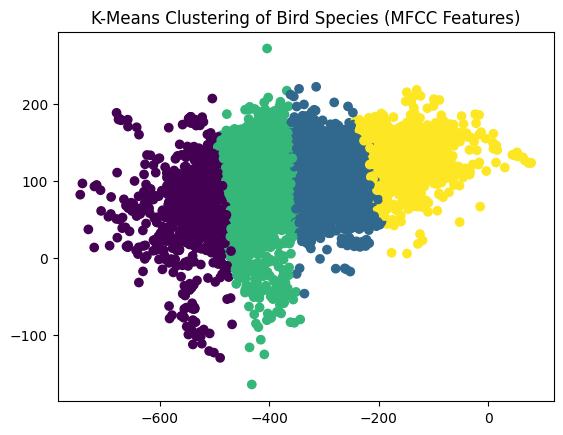

In [8]:
kmeans = KMeans(n_clusters=len(label_map), random_state=42)
kmeans_labels = kmeans.fit_predict(X)
# External evaluation
silhouette_avg = silhouette_score(X, kmeans_labels)
print(f"Silhouette Score: {silhouette_avg}")
ari = adjusted_rand_score(y, kmeans_labels)
print("Adjusted Rand Index:", ari)
# Graph
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap="viridis")
plt.title("K-Means Clustering of Bird Species (MFCC Features)")
plt.show()

# Deep Learning

extract mel-spectrum features(execute once)

In [ ]:
def extract_mel_spectrogram_for_species(species_folder):
    if not os.path.exists(species_folder):
        print(f"Error: {species_folder} does not exist!")
        return

    species_name = os.path.basename(species_folder)
    save_folder = f"{species_folder}_mel_spectrogram"  # New subfolder name
    os.makedirs(save_folder, exist_ok=True)  # Create folder if not exists

    for file in os.listdir(species_folder):
        if file.endswith(".wav"):
            file_path = os.path.join(species_folder, file)
            signal, sr = librosa.load(file_path, sr=None)
            mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            # Save as an image inside the new subfolder
            plt.figure(figsize=(3, 3))
            librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
            plt.axis("off")

            img_filename = file.replace(".wav", ".png")
            img_path = os.path.join(save_folder, img_filename)
            plt.savefig(img_path, bbox_inches="tight", pad_inches=0)
            plt.close()

    print(f"Mel spectrograms saved in: {save_folder}")

# Example usage (process only one species folder)
extract_mel_spectrogram_for_species("data/Passer_montanus")

Mel spectrograms saved in: data/Passer_montanus_mel_spectrogram


Loading data

In [ ]:
import torchvision.transforms as transforms
# Define image transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset directly from labeled subfolders
dataset = datasets.ImageFolder(root="mel_spectrograms", transform=transform)

# Split into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
print("create dataloaders")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Print class-to-label mapping
print("Class labels:", dataset.class_to_idx)

create dataloaders
Class labels: {'Anas_platyrhynchos': 0, 'Corvus_macrorhynchos': 1, 'Larus_canus': 2, 'Passer_montanus': 3}


define model

In [ ]:
class BirdSoundClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BirdSoundClassifier, self).__init__()
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Create model with correct number of classes
num_classes = len(dataset.classes)
model = BirdSoundClassifier(num_classes=num_classes)

training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Save trained model
torch.save(model.state_dict(), "efficientnet_bird_model.pth")

Epoch 1/10: 100%|██████████| 135/135 [16:53<00:00,  7.51s/batch]


Epoch 1/10, Loss: 41.6699, Accuracy: 89.64%


Epoch 2/10: 100%|██████████| 135/135 [00:34<00:00,  3.91batch/s]


Epoch 2/10, Loss: 16.9519, Accuracy: 95.88%


Epoch 3/10: 100%|██████████| 135/135 [00:33<00:00,  3.98batch/s]


Epoch 3/10, Loss: 9.9160, Accuracy: 97.70%


Epoch 4/10: 100%|██████████| 135/135 [00:34<00:00,  3.87batch/s]


Epoch 4/10, Loss: 12.1762, Accuracy: 97.11%


Epoch 5/10: 100%|██████████| 135/135 [00:34<00:00,  3.95batch/s]


Epoch 5/10, Loss: 8.3282, Accuracy: 97.91%


Epoch 6/10: 100%|██████████| 135/135 [00:35<00:00,  3.82batch/s]


Epoch 6/10, Loss: 7.8739, Accuracy: 98.39%


Epoch 7/10: 100%|██████████| 135/135 [00:34<00:00,  3.94batch/s]


Epoch 7/10, Loss: 6.0967, Accuracy: 98.56%


Epoch 8/10: 100%|██████████| 135/135 [00:35<00:00,  3.81batch/s]


Epoch 8/10, Loss: 3.7882, Accuracy: 99.07%


Epoch 9/10: 100%|██████████| 135/135 [00:33<00:00,  3.98batch/s]


Epoch 9/10, Loss: 2.2795, Accuracy: 99.63%


Epoch 10/10: 100%|██████████| 135/135 [00:35<00:00,  3.82batch/s]


Epoch 10/10, Loss: 4.3806, Accuracy: 98.98%


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Print confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)

# Print classification report
print("Classification Report:\n", classification_report(all_labels, all_preds))

Test Accuracy: 97.12%
Confusion Matrix:
 [[248   1   4   0]
 [  5 227   5   2]
 [  5   4 249   1]
 [  4   0   0 320]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       253
           1       0.98      0.95      0.96       239
           2       0.97      0.96      0.96       259
           3       0.99      0.99      0.99       324

    accuracy                           0.97      1075
   macro avg       0.97      0.97      0.97      1075
weighted avg       0.97      0.97      0.97      1075



## Experiments

#### (a) Effect of Training Data Size

In [ ]:
for fraction in [0.1, 0.2, 0.5, 0.8, 0.9]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-fraction, random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    print(f"SVM Accuracy with {fraction*100}% of data:", accuracy_score(y_test, y_pred_svm))

SVM Accuracy with 10.0% of data: 0.6781799379524301
SVM Accuracy with 20.0% of data: 0.7671009771986971
SVM Accuracy with 50.0% of data: 0.8056589724497394
SVM Accuracy with 80.0% of data: 0.8213953488372093
SVM Accuracy with 90.0% of data: 0.8085501858736059


#### (b) Effect of Data Balance (SMOTE)

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("Support Vector Machine Accuracy with SMOTE:", accuracy_score(y_test, y_pred_svm))

Support Vector Machine Accuracy with SMOTE: 0.8138629283489096


In [ ]:
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy with SMOTE:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy with SMOTE: 0.9610591900311527


#### (c) Effect of Data Augmentation (Noise Addition)

In [ ]:
def add_noise(signal, noise_level=0.005):
    noise = np.random.randn(len(signal)) * noise_level
    return signal + noise

X_augmented = np.array([np.mean(librosa.feature.mfcc(y=add_noise(librosa.util.normalize(librosa.load(os.path.join("data", species, file), sr=None)[0])),
                                                     sr=22050, n_mfcc=40), axis=1)
                         for species in os.listdir("data") for file in os.listdir(os.path.join("data", species)) if file.endswith(".wav")])
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y, test_size=0.2, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy with Noise Augmentation:", accuracy_score(y_test, y_pred_svm))
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy with Noise Augmentation:", accuracy_score(y_test, y_pred_rf))

SVM Accuracy with Noise Augmentation: 0.7767441860465116
Random Forest Accuracy with Noise Augmentation: 0.9237209302325582


#### (d) Effect of Dimensionality Reduction (PCA)

In [ ]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy with PCA:", accuracy_score(y_test, y_pred_svm))

SVM Accuracy with PCA: 0.8651162790697674


In [ ]:
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy with PCA:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy with PCA: 0.9441860465116279
